In [1]:
# Credit Scoring Pet Project
# Предсказание дефолта клиента по кредиту (Kaggle dataset)

## 1. Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import shap


In [7]:
# пример: Give Me Some Credit
df = pd.read_csv("cs-training.csv")

df.head()


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
df = df.drop(columns='Unnamed: 0')

In [9]:
df.corr()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.115386,0.125587,-0.007602,-0.019746,-0.029669,0.117175,-0.007038,0.102261,0.046048
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005898,-0.001314,0.003961,0.007124,-0.011281,-0.001061,0.006235,-0.001048,0.001557
age,-0.115386,-0.005898,1.000000,-0.062995,0.024188,0.037717,0.147705,-0.061005,0.033150,-0.057159,-0.213303
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001314,-0.062995,1.000000,-0.006542,-0.010217,-0.055312,0.983603,-0.030565,0.987005,-0.002680
DebtRatio,-0.007602,0.003961,0.024188,-0.006542,1.000000,-0.028712,0.049565,-0.008320,0.120046,-0.007533,-0.040673
MonthlyIncome,-0.019746,0.007124,0.037717,-0.010217,-0.028712,1.000000,0.091455,-0.012743,0.124959,-0.011116,0.062647
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.147705,-0.055312,0.049565,0.091455,1.000000,-0.079984,0.433959,-0.071077,0.065322
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.061005,0.983603,-0.008320,-0.012743,-0.079984,1.000000,-0.045205,0.992796,-0.010176
NumberRealEstateLoansOrLines,-0.007038,0.006235,0.033150,-0.030565,0.120046,0.124959,0.433959,-0.045205,1.000000,-0.039722,0.124684
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.057159,0.987005,-0.007533,-0.011116,-0.071077,0.992796,-0.039722,1.000000,-0.010922


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

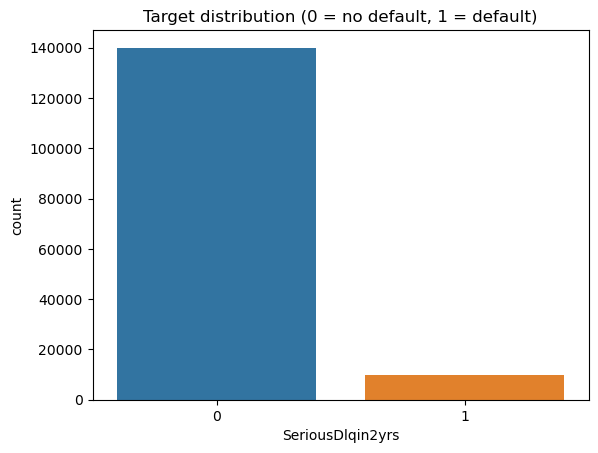

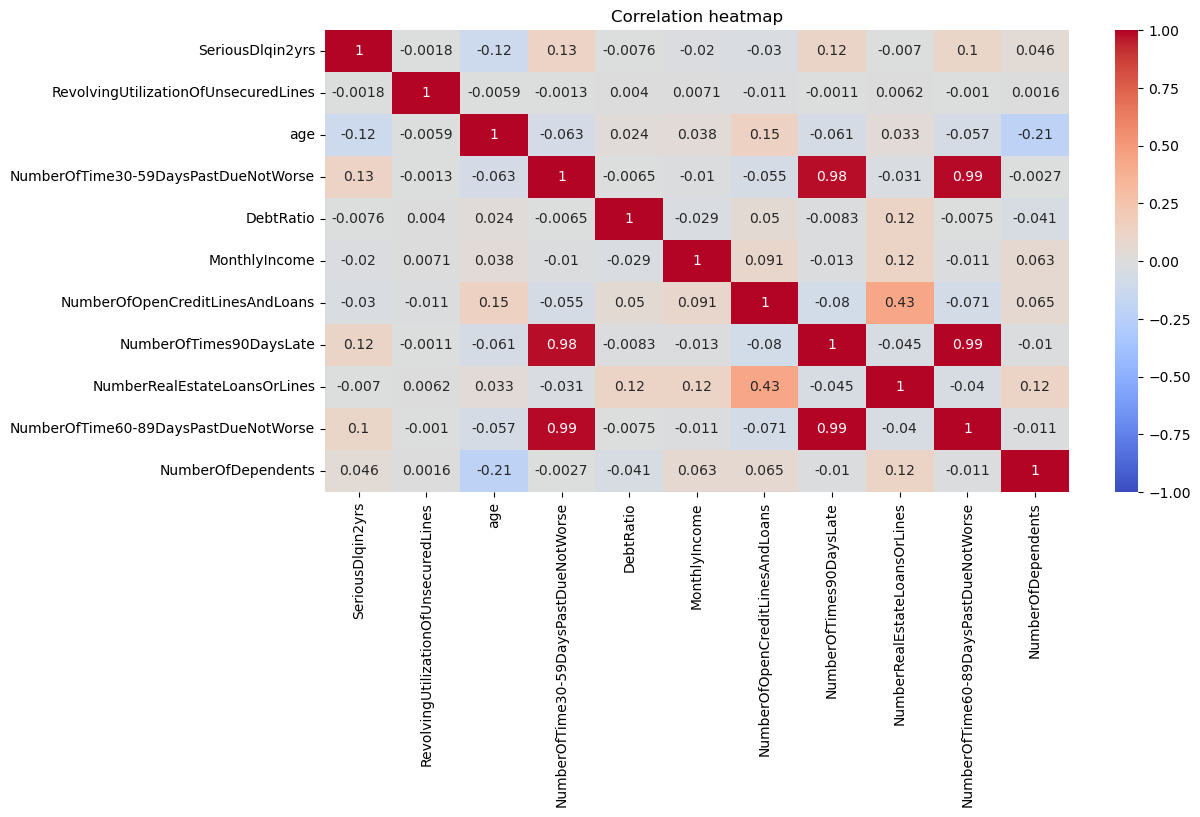

In [10]:
print(df.info())
print(df.describe())

# распределение target
sns.countplot(x="SeriousDlqin2yrs", data=df)
plt.title("Target distribution (0 = no default, 1 = default)")
plt.show()

# корреляции
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True)
plt.title("Correlation heatmap")
plt.show()


In [4]:
df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [11]:
# целевая переменная
y = df["SeriousDlqin2yrs"]
X = df.drop(columns=["SeriousDlqin2yrs"])

# пропуски → медиана
X = X.fillna(X.median())

# масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# балансировка
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [12]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name}: ROC-AUC = {auc:.4f}")


Logistic Regression: ROC-AUC = 0.7950
Random Forest: ROC-AUC = 0.8270


C:\Users\Пользователь\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: ROC-AUC = 0.8370
[LightGBM] [Info] Number of positive: 111979, number of negative: 111979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 223958, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM: ROC-AUC = 0.8527
CatBoost: ROC-AUC = 0.8525


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27995
           1       0.42      0.39      0.40      2005

    accuracy                           0.92     30000
   macro avg       0.69      0.68      0.68     30000
weighted avg       0.92      0.92      0.92     30000



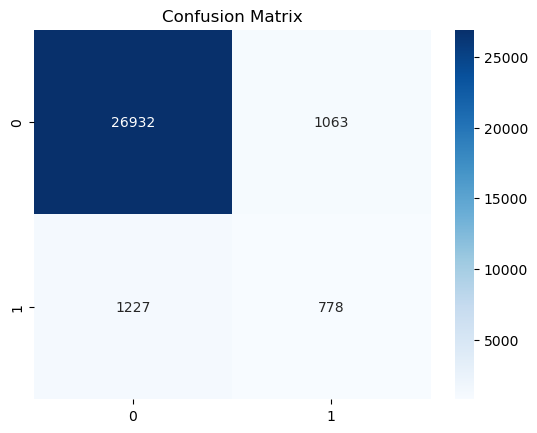

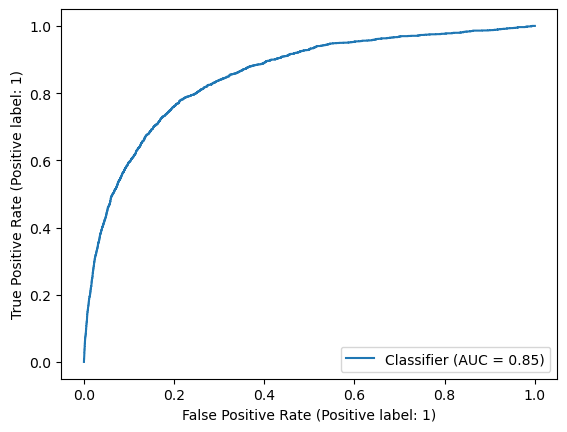

In [13]:
best_model = models["LightGBM"]  # допустим, лучший

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC кривая
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


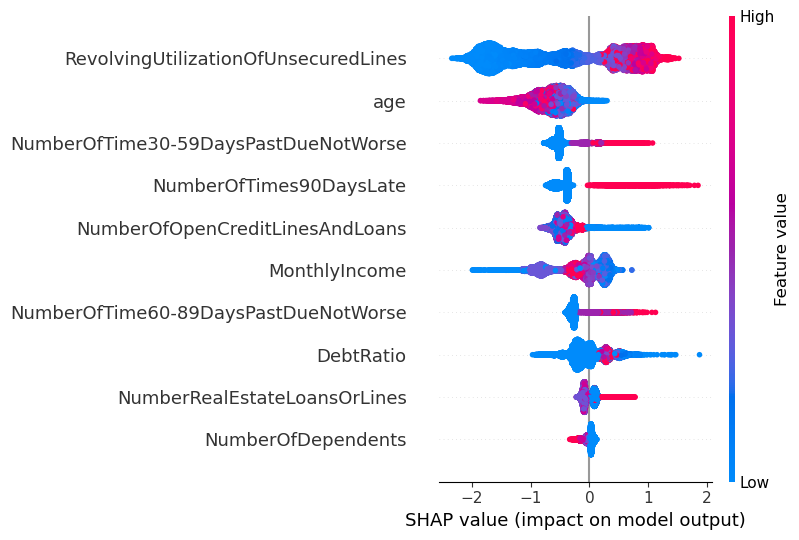

In [14]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


### Выводы
Модель LightGBM показала ROC-AUC = 0.85.

Главные факторы дефолта: количество просрочек, уровень дохода, возраст клиента.

Модель можно использовать как систему поддержки принятия решений в банке.
